# Benchmarking for predicting Radiative heating using a scaled-flux approach and a convolutional NN
### First time users are recommended to examine demo radiation to explore the data.

The purpose of this notebook is to benchmark one possible solution to the problem. This approach aims to predict the heating rates and fluxes for short-wave heating. Knowing the incoming top-of-atmosphere fluxes are prescribed by incoming solar radiation we can use this as a normalisation technique for the loss. This was found to give better results than a mse on the shortwave fluxes. 

We will use a convolutional neural network, we will add dilation to first convolutional layers to allow information to propagate more quickly through the vertical column.

In [1]:
#If you do not yet have climetlab and the radiation dataset.

#pip install climetlab
#pip install climetlab_maelstrom_radiation

In [2]:
#If running on EWC to avoid redownloading data
import os
os.environ['CLIMETLAB_MIRROR']='https://storage.ecmwf.europeanweather.cloud file:///mnt'
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
import climetlab as cml

2021-11-30 15:55:24.744053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 15:55:24.862047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 15:55:24.862873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Create datasets for training and validation
This uses quite a large amount of data, which was found to be necessary ...
We precscribe a training and validation dataset using the timestep and filenum arguments. 
Here we are trying to predict the shortwave fluxes 'sw' and the shortwave heating rate 'hr_sw'.
We set the heating rate units to be 'K d-1' instead of 'K s-1', so that the output is O(1).

In [5]:
batch_size = 512

big_data = False

if big_data:
    ds_cml = cml.load_dataset('maelstrom-radiation-tf',dataset='tripleclouds',
                      output_fields=['sw','hr_sw'],
                      timestep=list(range(0,3501,500)),
                      filenum = list(range(0,51,5)),
                      hr_units = 'K d-1',
                      norm=False              )
else:
    ds_cml = cml.load_dataset('maelstrom-radiation-tf',dataset='tripleclouds',
                      hr_units = 'K d-1',
                      output_fields=['sw','hr_sw'],norm=False)

if big_data:
    ds_cml_val = cml.load_dataset('maelstrom-radiation-tf',
                         dataset='tripleclouds',
                         timestep=2019013100,
                         filenum = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         output_fields = ['hr_sw','sw'],
                         hr_units = 'K d-1',
                         norm = False,
                        )
else:
    ds_cml_val = cml.load_dataset('maelstrom-radiation-tf',
                         dataset='tripleclouds',
                         timestep=2019013100,
                         filenum = [0],
                         output_fields = ['hr_sw','sw'],
                         hr_units = 'K d-1',
                         norm = False,
                        )    


train = ds_cml.to_tfdataset(batch_size=batch_size,shuffle=True)

val = ds_cml_val.to_tfdataset(batch_size=batch_size,shuffle=False)



  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv1D,Add,RepeatVector,ZeroPadding1D,Reshape
from tensorflow.keras.layers import Cropping1D,Concatenate,Multiply,Flatten,Dense
from tensorflow import nn
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [7]:
#Custom layer to calculate the heating rate from the flux profiles.
# this calculates the net (down - up) flux, the takes the derivative
# with respect to pressure.
@tf.keras.utils.register_keras_serializable()
class HRLayer(tf.keras.layers.Layer):
    #Calculates the heating rates from the
    #Scaled fluxes, pressure and incoming solar
    def __init__(self,name=None,
                 g_cp = 9.80665 / 1004 * 24 * 3600 , #This needs rescaling for K s-1 HR units
                 **kwargs):
        super(HRLayer, self).__init__(name=name,**kwargs)
        self.g_cp = tf.constant(g_cp)
        
    def build(self, input_shape):
        pass

    def call(self, inputs):
        fluxes = inputs[0]
        hlpress = inputs[1]
        
        netflux = fluxes[...,0] - fluxes[...,1]
        flux_diff = netflux[...,1:] - netflux[...,:-1]
        net_press = hlpress[...,1:,0]-hlpress[...,:-1,0]
        return -self.g_cp * tf.math.divide(flux_diff,net_press)

In [8]:
#Load normalisation (the column max for each feature)
#this file is stored with the notebook (in case linking doesn't work)
import numpy as np
norms = np.load('inp_max_norm.npy',allow_pickle=True)
norms = norms[()]
for key in norms:
    norms[key][norms[key]==0] = 1
norms

{'sca_inputs': array([3.4412103e+02, 9.9760216e-01, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 9.0557474e-01, 8.5934466e-01, 8.6474800e-01,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 9.0621883e-01,
        9.0155667e-01, 9.0155667e-01, 9.9000025e-01, 1.0012065e+00,
        1.4071930e+03], dtype=float32),
 'col_inputs': array([3.02850120e-02, 1.75108307e-05, 4.25841426e-04, 3.32709419e-07,
        2.05031301e-06, 2.09439978e-01, 8.65664040e-10, 4.97483610e-10,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.81228415e-09,
        3.06694574e-07, 3.72612533e-07, 1.16950666e-07, 3.83020847e-07,
        5.07950915e-07, 3.52568293e-07, 2.95319722e-07, 1.50701158e-08,
        3.90490698e-08, 2.67124456e-08, 4.74221939e-10, 4.32739034e-03,
        1.22224241e-02, 2.99999992e-05, 1.00675599e-04], dtype=float32),
 'hl_inputs': array([   330.89767, 107193.51   ], dtype=float32),
 'inter_inputs': array([0.9932044], dtype=float32),
 'pressure_hl': array([107193.51], dt

In [9]:
#We build a custom loss to train on the mse of the scaled fluxes.
# scaling is done by the incoming solar radiation, which can 
# also be calculated from the cos_solar_zenith_angle * incoming_radiation
# this value is always > 0, so we don't need to worry about NaNs.

mse = tf.keras.losses.MeanSquaredError()
def scaledflux_mse(y_true,y_pred):
    sca = global_incoming_radiation * cos_solar_zenith_angle #y_true[...,:1,:1]
    y_true_tmp = y_true / sca
    y_pred_tmp = y_pred / sca
    return mse(y_true_tmp,y_pred_tmp)



In [38]:
#Here we construct a model.
    
def buildmodel(input_shape,
               output_shape,
    kernel_width = 5,
    conv_filters = 64,
    dilation_rates =  [1,2,4,8,16],
    conv_layers = 6,
    batch_norm = False,
              ):
    inputs = {}

    #Inputs are a bit messy, in the next few lines we create the input shapes,    
    for k in input_shape.keys():
        inputs[k] = Input(input_shape[k].shape[1:],name=k)
        
    # Calculate the incoming solar radiation before it is normalised.
    in_solar = inputs['sca_inputs'][...,1:2]*inputs['sca_inputs'][...,-1:]
    #Pressure needs to be un-normalised.
    hl_p = inputs['pressure_hl']
    
    #Normalise them by the columnar-maxes
    normed = {}
    for i,k in enumerate(input_shape.keys()):
        normed[k]= inputs[k]/tf.constant(norms[k])
    
    # and repeat or reshape them so they all have 138 vertical layers
    rep_sca = RepeatVector(138)(normed['sca_inputs'])
    col_inp = ZeroPadding1D(padding=(1,0))(normed['col_inputs'])
    inter_inp = ZeroPadding1D(padding=(1,1))(normed['inter_inputs'])
    all_col = Concatenate(axis=-1)([rep_sca,col_inp,normed['hl_inputs'],inter_inp])

    #Use dilation to allow information to propagate faster through the vertical.
    for drate in dilation_rates:
        all_col = Conv1D(filters=conv_filters,kernel_size = kernel_width,
                         dilation_rate = drate,padding='same',
                         data_format='channels_last',
                         activation = nn.swish)(all_col)
    #Conv layers
    for i in range(conv_layers):
        all_col = Conv1D(conv_filters,
                         kernel_size=kernel_width,
                         padding='same',
                         strides=1,
                         data_format='channels_last',
                        )(all_col)

    #Fluxes cannot be larger than 1 before scaling of incoming solar
    sw = Conv1D(filters=2,padding='same',kernel_size=kernel_width,
                data_format='channels_last',
                activation='sigmoid')(all_col)
                                    
    #Multiply by incoming solar rad.
    sw = Multiply(name='sw')([sw,in_solar])
    
    #Use custom layer to calculate HR from fluxes
    sw_hr = HRLayer(name='hr_sw')([sw, hl_p])
    #Dictionary of outputs
    output = {'hr_sw':sw_hr,
             'sw':sw}

    model = Model(inputs,output)
    model.compile(loss={'hr_sw':'mse', #tf.keras.losses.log_cosh,
                        'sw':scaledflux_mse},
                  loss_weights = {'hr_sw':10**(-2),
                        'sw':1},
                  metrics={#'hr_sw':'mse',
                          'sw':'mse',
                          },
                  optimizer=Adam(10**(-5)))
    return model

In [39]:
input_shape = train.element_spec[0]
output_shape = train.element_spec[0]

model = buildmodel(input_shape,output_shape)

## Train the model. 
### On a V100, with slow-ish data connection, this takes 52ms/step.
Depending on which dataset you use this could take ~600s


In [40]:
#Train the model. 
#On a V100, with slow-ish data connection, this takes 52ms/step.
hist = model.fit(train,validation_data=val,epochs=1)

11660/11660 [==============================] - 520s 44ms/step - loss: 0.1761 - hr_sw_loss: 8.0549 - sw_loss: 0.0956 - sw_mse: 43173.3633 - val_loss: 0.0941 - val_hr_sw_loss: 2.1229 - val_sw_loss: 0.0729 - val_sw_mse: 39476.5938


# Only proceed if you care about science metrics and plotting ....
### on my machine this took 8 hours...

In [46]:
#Only run if you care about science metrics and plotting ....
hist = model.fit(train,validation_data=val,epochs=50)

Epoch 1/50
11660/11660 [==============================] - 569s 49ms/step - loss: 0.0802 - hr_sw_loss: 1.9905 - sw_loss: 0.0603 - sw_mse: 34853.1367 - val_loss: 0.0683 - val_hr_sw_loss: 1.4500 - val_sw_loss: 0.0538 - val_sw_mse: 33900.5898
Epoch 2/50
11660/11660 [==============================] - 562s 48ms/step - loss: 0.0676 - hr_sw_loss: 1.8109 - sw_loss: 0.0495 - sw_mse: 31343.6602 - val_loss: 0.0598 - val_hr_sw_loss: 1.4212 - val_sw_loss: 0.0456 - val_sw_mse: 31008.2500
Epoch 3/50
11660/11660 [==============================] - 581s 50ms/step - loss: 0.0611 - hr_sw_loss: 1.7990 - sw_loss: 0.0431 - sw_mse: 29068.7578 - val_loss: 0.0510 - val_hr_sw_loss: 1.0714 - val_sw_loss: 0.0403 - val_sw_mse: 28833.1875
Epoch 4/50
11660/11660 [==============================] - 575s 49ms/step - loss: 0.0563 - hr_sw_loss: 1.7980 - sw_loss: 0.0383 - sw_mse: 27166.0098 - val_loss: 0.0466 - val_hr_sw_loss: 0.9778 - val_sw_loss: 0.0369 - val_sw_mse: 27475.5215
Epoch 5/50
11660/11660 [====================

## What are good numbers?
Ideally we would like val_hr_sw_mse ~ 0.002 and val_sw_mse ~ 30.

Typically, with this model you will get val_hr_sw_mse ~ 0.34 and val_sw_mse ~ 4000 with big data...

## Quick visualisation of the results

In [47]:
#Grab the first batch of data.
for inps,outs in val:
    break
    
#Predict the outputs
pred = model.predict(inps)

In [48]:
import matplotlib.pyplot as plt

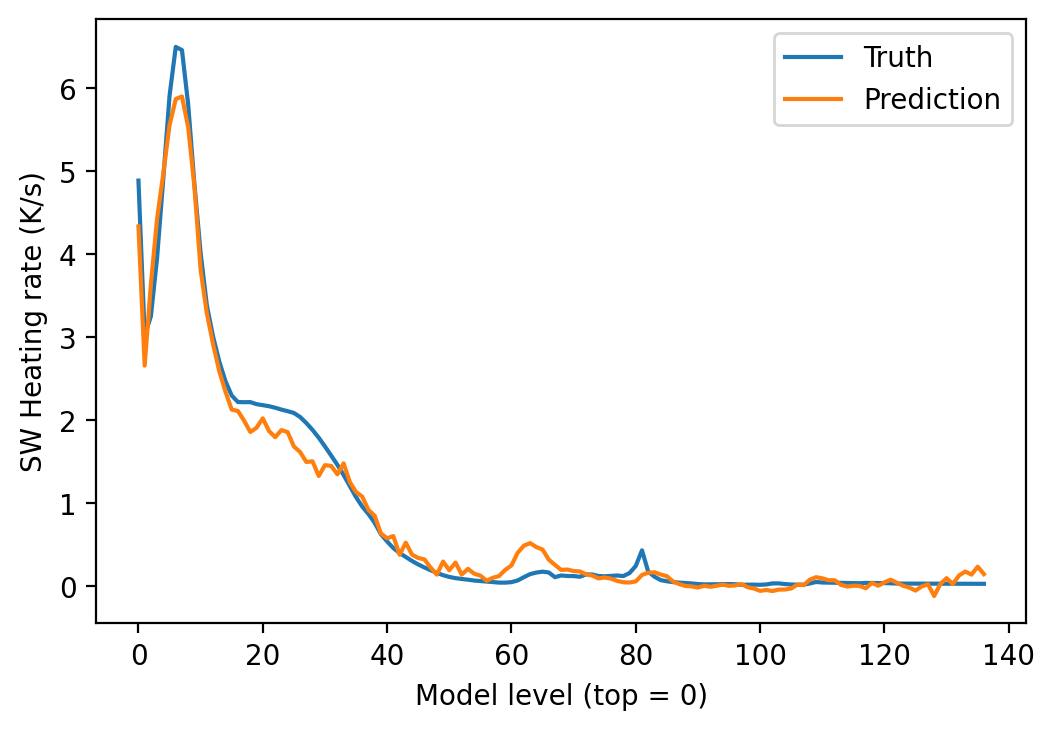

In [49]:
#Plot the first element of the batch
plt.figure(dpi=200)
plt.plot(outs['hr_sw'][0,:],label='Truth')
plt.plot(pred['hr_sw'][0,:],label='Prediction')
plt.ylabel('SW Heating rate (K/s)')
plt.xlabel('Model level (top = 0)')
plt.legend()

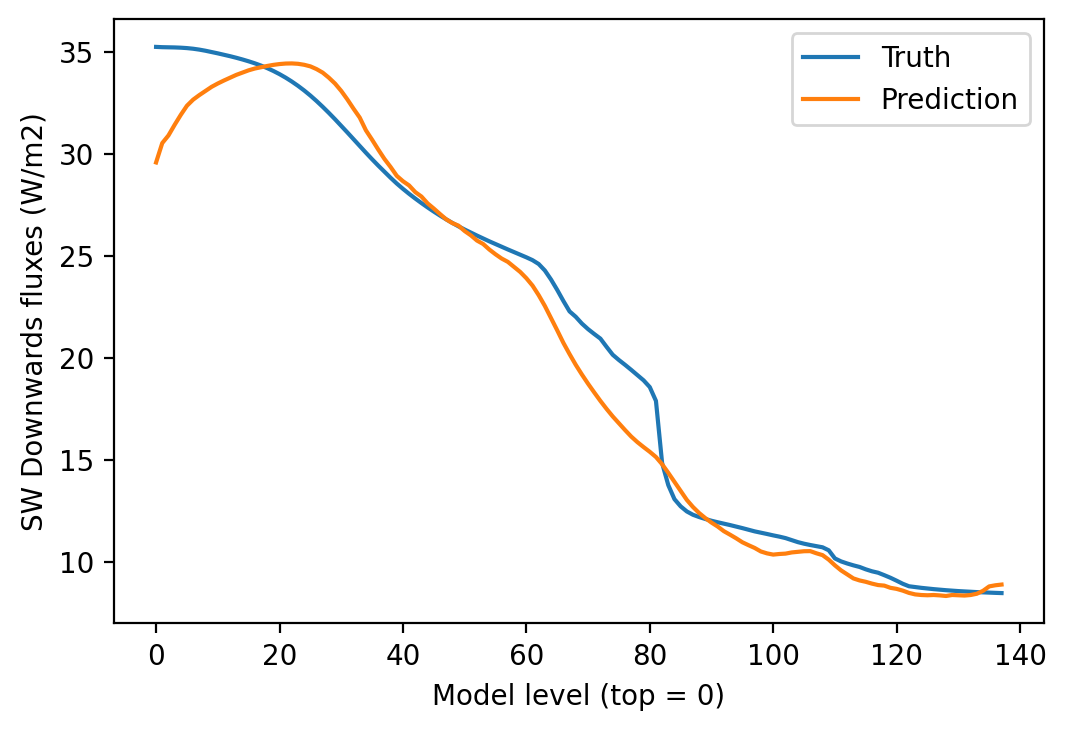

In [50]:
#Plot the downwards fluxes
plt.figure(dpi=200)
plt.plot(outs['sw'][0,:,0],label='Truth')
plt.plot(pred['sw'][0,:,0],label='Prediction')
plt.ylabel('SW Downwards fluxes (W/m2)')
plt.xlabel('Model level (top = 0)')
plt.legend()

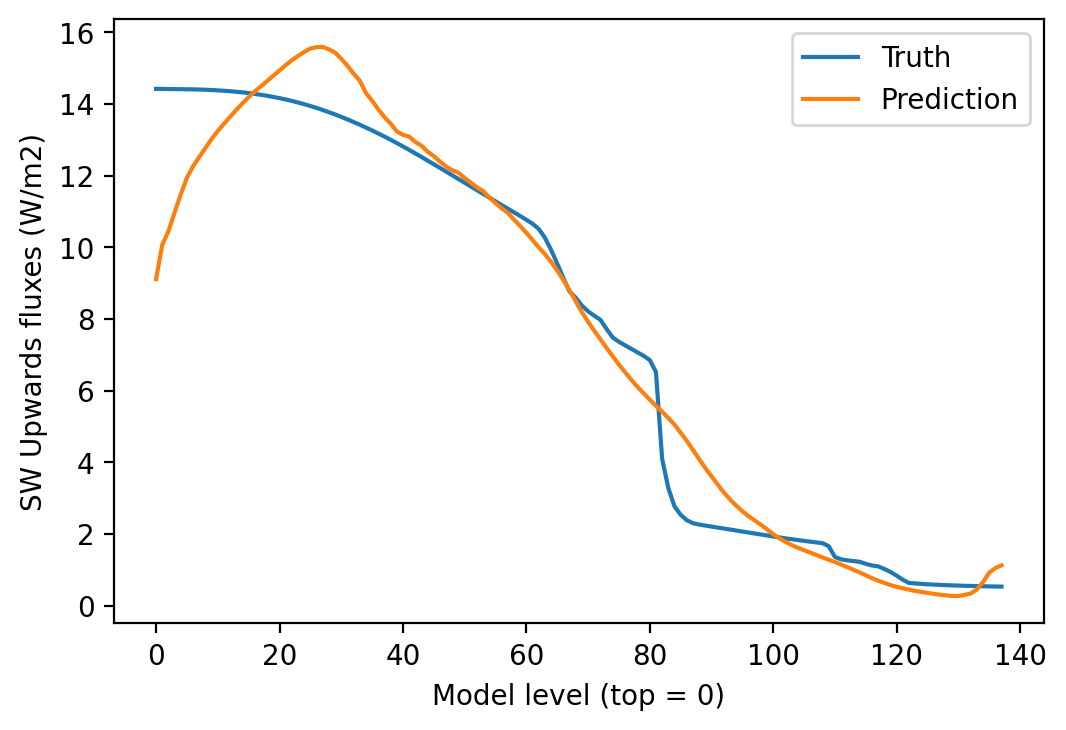

In [51]:
#Plot the upwards fluxes
plt.figure(dpi=200)
plt.plot(outs['sw'][0,:,1],label='Truth')
plt.plot(pred['sw'][0,:,1],label='Prediction')
plt.ylabel('SW Upwards fluxes (W/m2)')
plt.xlabel('Model level (top = 0)')
plt.legend()


# What have we learnt?
We are doing an OK job of predicting the fluxes, but small errors in the fluxes are magnified by the heating rate calculation. Particularly at the top of the atmosphere we get large errors.

### Perhaps you can think of improvements to our convolutional model?